In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

from feature_names import *
from utils import *

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder

In [22]:
df_train = pd.read_csv('../Data/competition/train_data.csv')
df_test = pd.read_csv('../Data/competition/test_data.csv')
dfs = [df_train, df_test]

In [27]:
submit_index = df_test[index]

In [4]:
print(df_test.info())
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31354 entries, 0 to 31353
Columns: 245 entries, index to wind-vwnd-925-2010-20
dtypes: float64(241), int64(2), object(2)
memory usage: 58.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: float64(240), int64(4), object(2)
memory usage: 705.2+ MB
None


In [5]:
for df in dfs:
  df.columns = df.columns.str.replace('-','_')

In [6]:
df_info_obj = df_info(df_train)
null_contained_cols = df_info_obj[df_info_obj['nan_count']>0].index
df_info_obj.loc[null_contained_cols]

,nan_count,nan_percent,unique_count,dtype
nmme0_tmp2m_34w__ccsm30,15934,4.2408,3840,float64
nmme_tmp2m_56w__ccsm3,10280,2.7360,5000,float64
nmme_prate_34w__ccsm3,8738,2.3256,10139,float64
nmme0_prate_56w__ccsm30,15934,4.2408,5716,float64
nmme0_prate_34w__ccsm30,15934,4.2408,5712,float64
nmme_prate_56w__ccsm3,10280,2.7360,10008,float64
nmme_tmp2m_34w__ccsm3,8738,2.3256,4810,float64
ccsm30,15934,4.2408,3833,float64


In [7]:
for df in dfs:
  df[year] = df[startdate].str.split('/').str[2].astype(int)
  df[month] = df[startdate].str.split('/').str[0].astype(int)
  df[day] = df[startdate].str.split('/').str[1].astype(int)

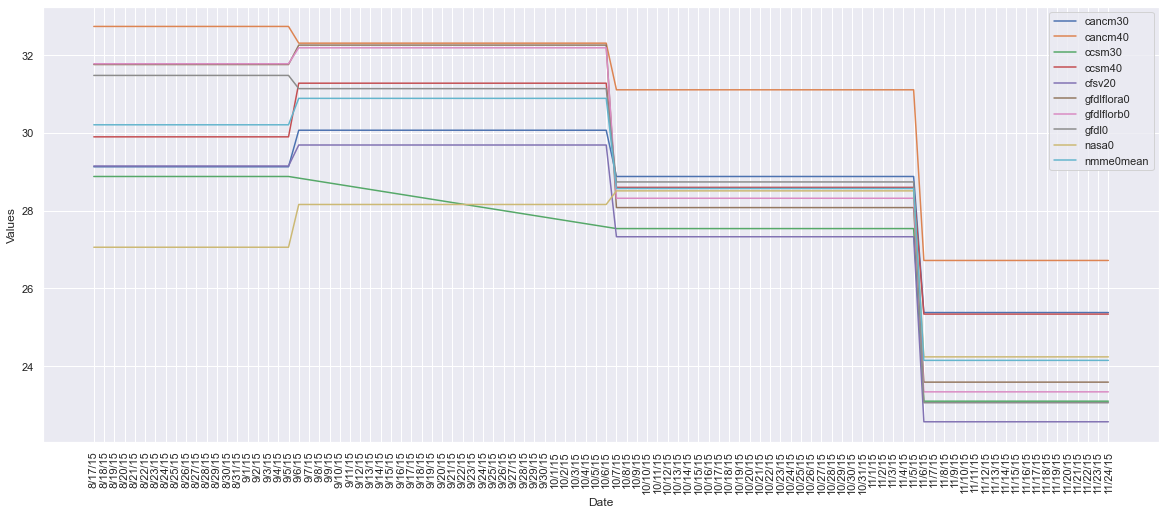

In [8]:
plot_line(
  df=df_train,
  column_name=[
    cancm30,
    cancm40,
    ccsm30,
    ccsm40,
    cfsv20,
    gfdlflora0,
    gfdlflorb0,
    gfdl0,
    nasa0,
    nmme0mean,
  ],
  start_index=350,
  end_index=450
)

In [9]:
# fill some missing values of one type model predict with mean of all models
# nmme0-tmp2m-34w__ccsm30
# nmme0-prate-34w__ccsm30
# nmme0-prate-56w__ccsm30
# nmme-tmp2m-56w__ccsm3
# nmme-tmp2m-34w__ccsm3
# nmme-prate-34w__ccsm3
# nmme-prate-56w__ccsm3
# ccsm30

df_train[nmme0_tmp2m_34w__ccsm30] = df_train[nmme0_tmp2m_34w__ccsm30].fillna(df_train[nmme0_tmp2m_34w__nmme0mean])
df_train[nmme0_prate_34w__ccsm30] = df_train[nmme0_prate_34w__ccsm30].fillna(df_train[nmme0_prate_34w__nmme0mean])
df_train[nmme0_prate_56w__ccsm30] = df_train[nmme0_prate_56w__ccsm30].fillna(df_train[nmme0_prate_56w__nmme0mean])
df_train[nmme_tmp2m_34w__ccsm3] = df_train[nmme_tmp2m_34w__ccsm3].fillna(df_train[nmme_tmp2m_34w__nmmemean])
df_train[nmme_tmp2m_56w__ccsm3] = df_train[nmme_tmp2m_56w__ccsm3].fillna(df_train[nmme_tmp2m_56w__nmmemean])
df_train[nmme_prate_34w__ccsm3] = df_train[nmme_prate_34w__ccsm3].fillna(df_train[nmme_prate_34w__nmmemean])
df_train[nmme_prate_56w__ccsm3] = df_train[nmme_prate_56w__ccsm3].fillna(df_train[nmme_prate_56w__nmmemean])
df_train[ccsm30] = df_train[ccsm30].fillna(df_train[nmme0mean])

In [10]:
# drop unused columns
for df in dfs:
  df.drop(columns=[
    startdate,
    index,
  ], inplace=True)

In [11]:
target = contest_tmp2m_14d__tmp2m
X, y = df_train.drop(columns=[target]), df_train[target]
X_submit = df_test

In [12]:
# split train, val and test keeping the same distribution of month and day

month_and_day = 'month_and_day'
X[month_and_day] = X[month].astype(str) +'-'+ X[day].astype(str)
X_train_temp, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=X[month_and_day])
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train, test_size=0.15784, random_state=42, stratify=X_train_temp[month_and_day])

In [13]:
# get sample data from train
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42, stratify=X_train[month_and_day])

In [14]:
temp = X_train[month_and_day].value_counts() / X_train.shape[0] - X[month_and_day].value_counts() / X.shape[0]
temp.describe()
# ==> oke

count    3.660000e+02
mean     1.149373e-19
std      1.656110e-06
min     -1.501754e-06
25%     -1.501754e-06
50%     -1.501754e-06
75%      1.824859e-06
max      1.824859e-06
Name: month_and_day, dtype: float64

In [15]:
X_train.drop(columns=[month_and_day], inplace=True)
X_val.drop(columns=[month_and_day], inplace=True)
X_test.drop(columns=[month_and_day], inplace=True)
X_train_sample.drop(columns=[month_and_day], inplace=True)

In [16]:
X_train.shape, X_val.shape, X_test.shape, X_submit.shape, X_train_sample.shape

((300606, 246), (56341, 246), (18787, 246), (31354, 246), (90181, 246))

In [17]:
# save train, val, test and submit data
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_sample = pd.concat([X_train_sample, y_train_sample], axis=1)
submit = X_submit

train.to_csv('../Data/created/train.csv', index=False)
val.to_csv('../Data/created/val.csv', index=False)
test.to_csv('../Data/created/test.csv', index=False)
train_sample.to_csv('../Data/created/train_sample.csv', index=False)

In [28]:
submit[index] = submit_index
submit.to_csv('../Data/created/submit.csv',index=False)

0        375734
1        375735
2        375736
3        375737
4        375738
          ...  
31349    407083
31350    407084
31351    407085
31352    407086
31353    407087
Name: index, Length: 31354, dtype: int64